Let $X^{L:m}_{(k,l)}$ denote the input image tensor procesed by 
the $m$-th map of layer $L$,
where $(k, l)$ denote position in the map. To complete the assignment:
1. **[1p]** Load a pre-trained model of a VGG network (e.g., VGG-19) and inspect its architecture.
  Classify at least 5 images of your
  choice (i.e. downloaded off the internet, not 5 more from Imagenet test set) and plot them along with top-5 predictions returned by the network. We provide a mapping from
  numerical class labels to textual descriptions.
  It is vital to apply the same pre-processing as the one which has been used during network training.

2. **[2p]** Implement and test heatmaps generated by iteratively occluding parts of the input image.
  * Implement a data iterator which takes an input image and iteratively occludes part of the image with a
    rectangle (see sample image above).
  * Implement a function `layer_activations(x, layer_name)` of
    the VGG network class,
    which taps into the network and returns activations of a chosen layer. 
    For each occluding position $(i, j)$ in the input image, we can record 
    sum of activations of feature map $m$ in layer $L$ as a heatmap
    $h_{(i,j)}^{L:m} = \sum_{k,l} X^{L:m}_{(k,l)}$. 
    Moving around the occluding rectangle
    changes the activations. Plot heatmaps $h^{L:m}$ for
    a few selected layers and images.
  * For each occluding position $(i, j)$ in the input image, we can record
    output probability of the true class $C$ and store it as $p(C|i,j)$.
    Plot such probability maps for a few images. Plot maps of network predictions
    $\text{argmax}_c p(c|i,j)$, which should reveal which occluding positions
    change the prediction of the network.

3. **[1p]** Faster heat-mapping using integrated gradients

    A quick and approximate method for computing the importance of a pixel is to compute the gradient of the output associated with the correct class with respect to the pixels. 
    
    However, better heatmaps can be obtained using the [Integrated Gradients](https://arxiv.org/abs/1703.01365) approach in which a series of gradients is computed, on images that range from a non-informative one (all gray) to the target image. 
    
    Implement intgrated gradients method: compute the gradients with respect the network's inputs for 50-300 images that linearly interpolate between an all-gray image and the target image. Then compute the magnitute of the gradients for the three channel of each pixel, and add all the magnitudes. Plot the resulting pixel saliencies and overlay them with the image, as shown in the example.

4. **[1p-2p]** Evaluate SHAP or LIME pixel attributions using a library implementation such as https://shap.readthedocs.io/en/stable/index.html or https://github.com/marcotcr/lime (this exercise is worth 1p per tested method).


5. **[1p]** Compare on a few images the workings of at least 2 attribution methods, such as SHAP, Integrated Gradients, or occlusions. Comment on their similarities and differences.

6. **[2p]** select a few neurons in each layer and try to find images to which they respond the most. Then visualize the gradient with respect to the input pixels at the mostly exciting patches. Try to recreate the figure 2 from M. Zieler Visualizing and Understanding Convolutional Neural Networks (https://arxiv.org/pdf/1311.2901.pdf)

# Starter code

In [1]:
%matplotlib inline

In [2]:
import logging

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn.functional as F
import torchvision
from torch import nn

logging.getLogger("PIL").setLevel(logging.INFO)


with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    import common.plotting

from utils import ILSVRC2014Sample, to_np, to_tensor, VGGPreprocess, CUDA

In [3]:
![ -e ../data/ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ../data/ilsvrc_subsample.tar.bz2
![ -d ../data/ilsvrc_subsample ] || tar -jxf ../data/ilsvrc_subsample.tar.bz2 -C ../data 

In [4]:
class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations."""

    FEATURE_LAYER_NAMES = {
        "vgg16": [
            "conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1", "conv2_1", "relu2_1", "conv2_2",
            "relu2_2", "pool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3",
            "pool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3", "pool4",
            "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3", "pool5",
        ],
        "vgg19": [
            "conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1", "conv2_1", "relu2_1", "conv2_2",
            "relu2_2", "pool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3",
            "conv3_4", "relu3_4", "pool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
            "relu4_3", "conv4_4", "relu4_4", "pool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2",
            "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5",
        ],
    }

    def __init__(self, model="vgg19"):
        super(VGG, self).__init__()
        all_models = {"vgg16": torchvision.models.vgg16, "vgg19": torchvision.models.vgg19}
        vgg = all_models[model](pretrained=True)

        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax(dim=-1)

        self.feature_names = self.FEATURE_LAYER_NAMES[model]

        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        return F.softmax(logits, dim=-1)

    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError("Layer %s not found" % layer_name)

    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        pass # TODO implement me

    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self(x)
        return logits.argmax(-1)


vgg = VGG("vgg19")

if CUDA:
    vgg.cuda()

In [5]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

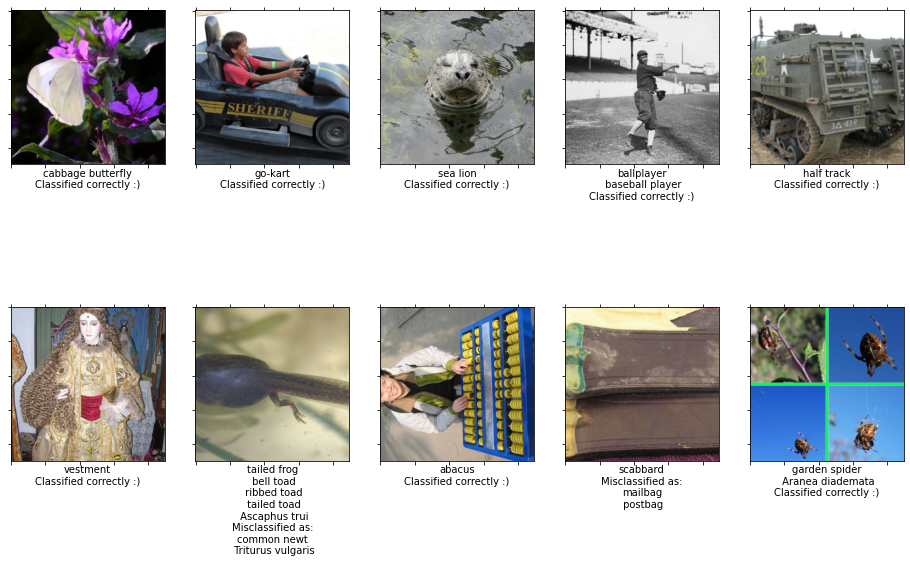

In [6]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

plt.figure(figsize=(16, 10))
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]

    desc = ilsvrc.label_to_desc[label].split(",")
    if label == predicted_label:
        desc.append("Classified correctly :)")
    else:
        desc.append("Misclassified as:")
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(","))

    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

## Problem 1

### 1.1 Implement classification of your own images below

In [7]:
from pathlib import Path

import PIL
import torchvision.io
import torchvision.transforms

In [8]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(256), torchvision.transforms.CenterCrop(224)])

In [9]:
def load_image(filepath: str) -> np.ndarray:
    img = transform(PIL.Image.open(filepath).convert("RGB"))
    return np.asarray(img).astype("float32") / 255.0

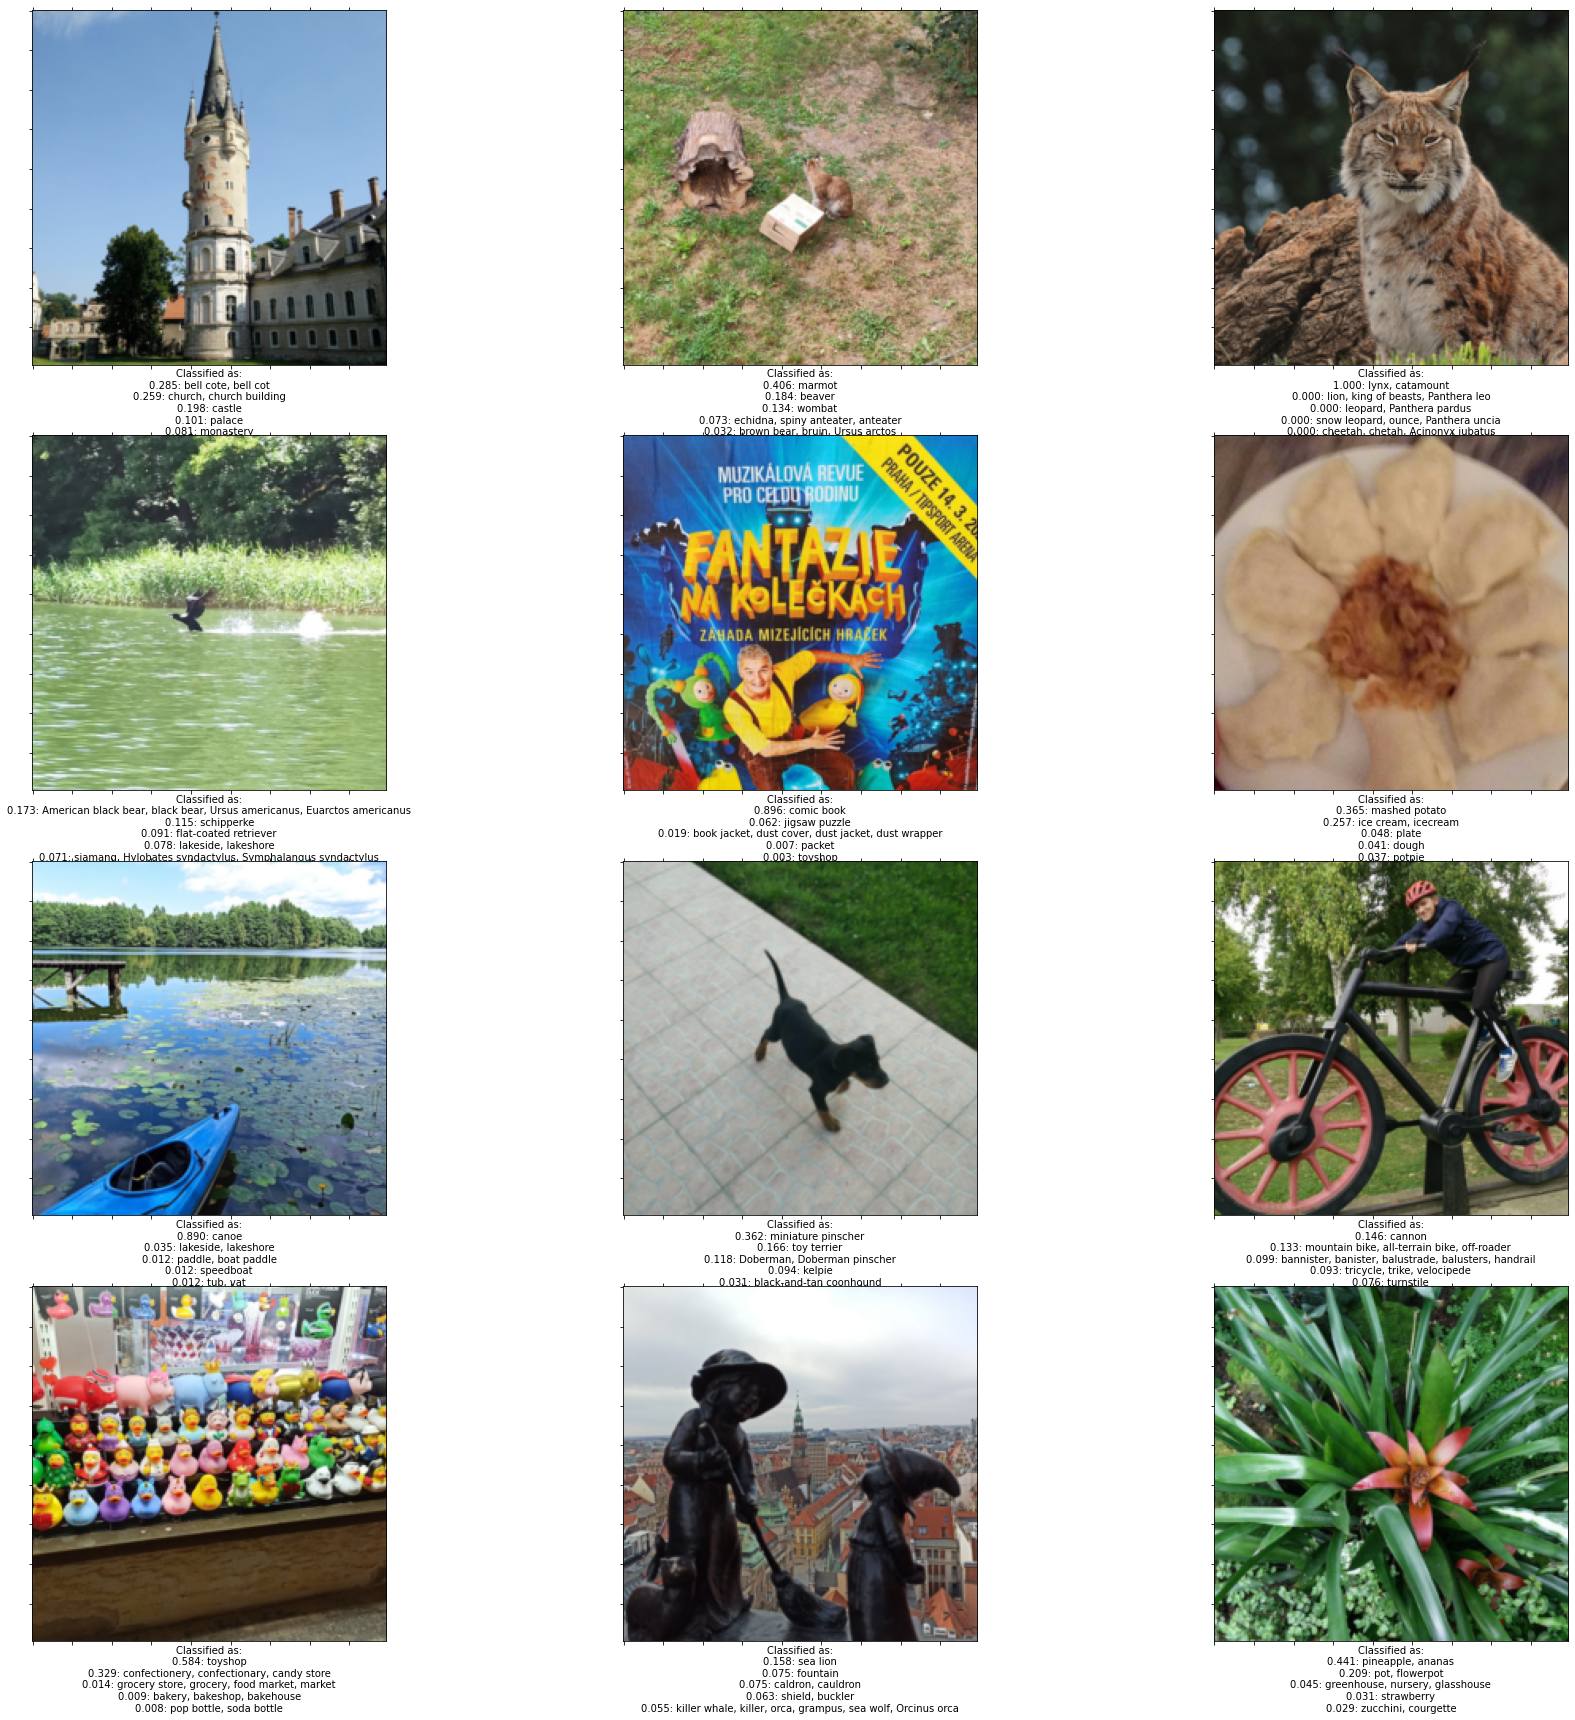

In [10]:
plt.figure(figsize=(30, 30))
for i, filepath in enumerate(Path("../data/new_images").iterdir()):
    img = load_image(filepath)
    img_torch = to_tensor(img)
    probs = vgg.probabilities(img_torch).squeeze()
    top5 = probs.sort(-1, descending=True)[1][:5]

    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    desc = ["Classified as:"]
    for pred_id in top5:
        pred_label = ilsvrc.label_to_desc[ilsvrc.id_to_label[pred_id.item()]]
        pred_prob = probs[pred_id].item()
        desc.append(f"{pred_prob:.3f}: {pred_label}")

    ax = plt.subplot(4, 3, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

### 1.2 Analyse the responses of the network when part of the input is obscured

In [11]:
def obscured_imgs(img, boxsize=8, bsz=64, stride=4):
    batch = []
    for i in range(0, img.shape[0] - boxsize + 1, stride):
        for j in range(0, img.shape[1] - boxsize + 1, stride):
            img_copy = np.copy(img)
            img_copy[..., i:i+boxsize, j:j+boxsize, :] = np.array([0.485, 0.456, 0.406])
            batch.append(img_copy)
            if len(batch) == bsz:
                yield np.stack(batch)
                batch = []
    yield np.stack(batch)

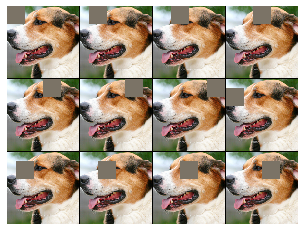

In [12]:
# Show samples from an obscured batch
batch = next(obscured_imgs(ilsvrc.data[27], boxsize=56, bsz=12, stride=28))
batch = np.vstack([im[None] for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [13]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [14]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx]

# if you run out of GPU mem split batch into smaller ones
bsz = 32
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ["heat", "prob", "pred"]
maps = {mt: [] for mt in map_types}
for batch in obscured_imgs(img, boxsize, bsz, stride):
    with torch.no_grad():
        batch = to_tensor(batch)
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 and neuron #1
        maps["heat"].append(to_np(vgg.layer_activations(batch, "conv2_1"))[:, 1].sum(axis=(1, 2)))
        maps["prob"].append(to_np(vgg.probabilities(batch))[:, ilsvrc.label_to_id[label]])
        maps['pred'].append(to_np(vgg.predict(batch)))

for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

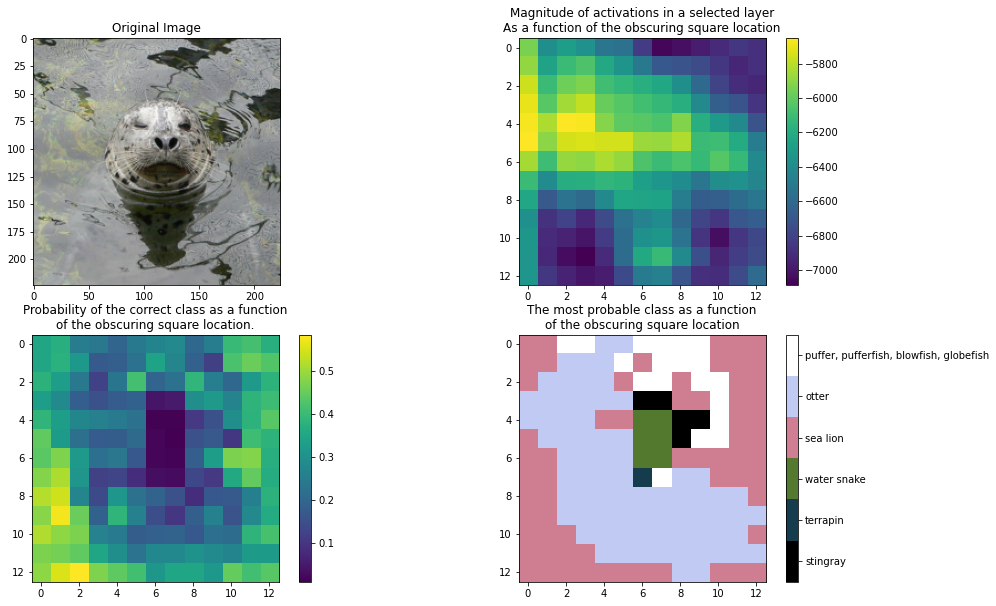

In [15]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(maps["heat"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Magnitude of activations in a selected layer\n"
    "As a function of the obscuring square location"
)

plt.subplot(2, 2, 3)
plt.imshow(maps["prob"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Probability of the correct class as a function\n"
    "of the obscuring square location."
)

plt.subplot(2, 2, 4)
discrete = np.zeros_like(maps["pred"], dtype=np.int64)
values = np.unique(maps["pred"]).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps["pred"] == v)] = i
num_values = max(values.shape[0], 1)
plt.imshow(discrete, cmap=discrete_cmap(num_values, "cubehelix"))
plt.grid(False)
cb = plt.colorbar(
    ticks=np.arange(
        (num_values - 1.0) / num_values / 2.0,
        num_values,
        (num_values - 1.0) / num_values,
    )
)
cb.set_ticks(
    np.arange(0.5 - 0.5/num_values, num_values - 1, 1 - 1/num_values),
    labels=[ilsvrc.id_to_desc[v] for v in values],
)
plt.title("The most probable class as a function\n" "of the obscuring square location")
plt.show()

### 1.3 [Integrated Gradients](https://arxiv.org/abs/1703.01365)

In [30]:
idx = 16
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx]

predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

print(
    "Predicted: %s (correct: %s)"
    % (ilsvrc.id_to_desc[predicted_id], ilsvrc.label_to_desc[label])
)

num_integration_points = 300

batch_size = 20

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype("float32")[
    :, None, None, None
]
grads = []

for i in range(0, num_integration_points, batch_size):
    # TODO: batch contains a subset of images interpolating between the all gray image and the selected image
    batch = weights[i : i + batch_size] * img + (1.0 - weights[i : i + batch_size]) * (np.zeros_like(img) + 0.5)
    batch = to_tensor(batch, requires_grad=True)

    # TODO: Get the probabilities for the correct class
    prediction = torch.sum(vgg.probabilities(batch)[:, predicted_id])
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

importance_scores = np.abs(grads.sum((0, -1)))

Predicted: axolotl, mud puppy, Ambystoma mexicanum (correct: sea anemone, anemone)


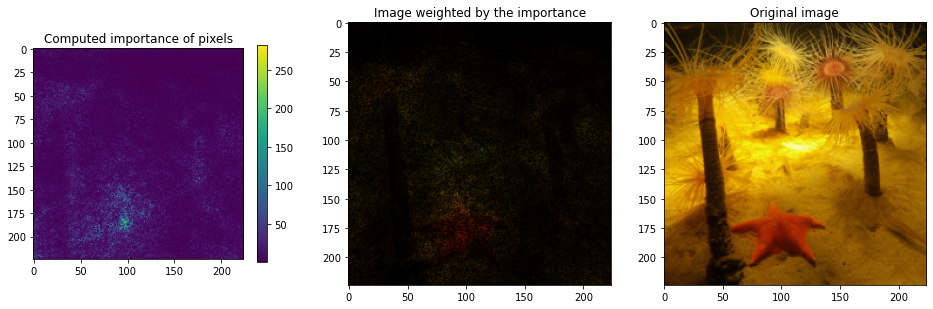

In [31]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(importance_scores, cmap="viridis")
plt.colorbar(shrink=0.4)
plt.title("Computed importance of pixels")
plt.grid(False)

plt.subplot(1, 3, 2)
# normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7  # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:, :, None])
plt.title("Image weighted by the importance")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.title("Original image")
plt.grid(False)

### 1.4 SHAP pixel imprtances

### 1.5 Comparison of importance attribution methods

### 1.6 Find image patches that activate selected neurons

## Problem 2 Starter Code

In [ ]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

In [ ]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

In [ ]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indexes)

In [ ]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

Downloading...
From: https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
To: /content/101_ObjectCategories.tar.gz
132MB [00:02, 63.5MB/s]


In [ ]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [ ]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


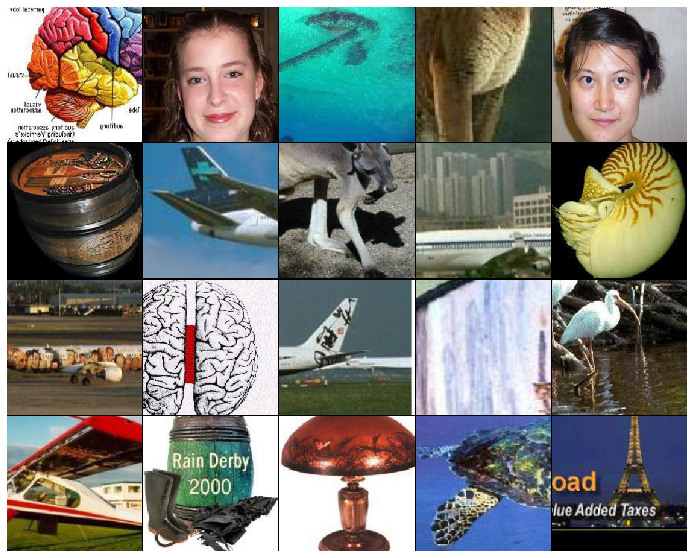

In [ ]:
train_batch = next(iter(caltech_loaders["train"]))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [ ]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [ ]:
# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, data_loaders, optimizer, criterion, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())

                                
                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:

                                
                best_epoch = epoch
                best_val_err = val_err_rate

                
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)


def plot_history(history):
    figsize(16, 4)
    subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    legend()

    subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    ylim(0, 20)
    legend()

Training the model!
You can interrupt it at any time.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Minibatch     50  | loss  1.68 | err rate 43.75%
Minibatch    100  | loss  1.41 | err rate 42.19%
----------------------------------------------------------
After epoch  1 | valid err rate: 14.22% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.76 | err rate 20.31%
Minibatch    200  | loss  0.75 | err rate 15.62%
----------------------------------------------------------
After epoch  2 | valid err rate: 10.28% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.62 | err rate 15.62%
Minibatch    300  | loss  0.86 | err rate 25.00%
----------------------------------------------------------
After epoch  3 | valid err rate: 10.93% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.68 | err rate 20.31%
Minibatch    400  | loss  0.53 | err rate 15.62%
Minibatch    450  | loss  0.61 | err rate 15.62%
----------------------------

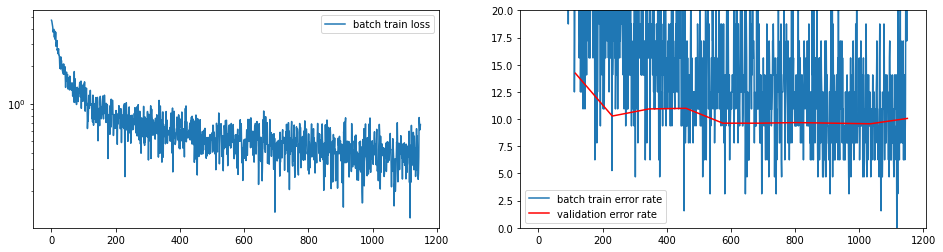

In [ ]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = TODO

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)

## Problem 3 Starter Code

In [ ]:
![ -e images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O images.tar.bz2
![ -d images ] || tar jxf images.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF
To: /content/images.tar.bz2
13.5MB [00:00, 51.3MB/s]


In [ ]:
!ls images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


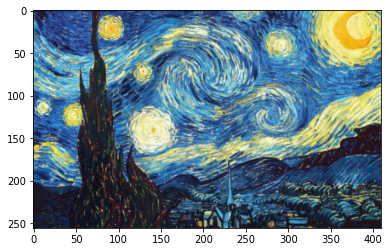

In [ ]:
def load_image(path, size=256):
    img = PIL.Image.open(path)
    img = img.convert("RGB")
    img = torchvision.transforms.Resize(size)(img)
    return numpy.asarray(img).astype("float32") / 255.0


imshow(load_image("images/starry_night.jpg"))
grid(False)

In [ ]:
class StyleTransferNet(object):
    def __init__(
        self,
        style_layers,
        content_layers,
        vgg_model="vgg19",
        content_weight=5e0,
        style_weight=1e2,
    ):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()

    def capture_content(self, x):
        # TODO: implement saving naural activations for a chosen set of content layers
        self.content_captures = TODO

    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(x, self.style_layers)
        self.style_captures = [self._gram_mat(l).detach() for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(x, needed_layers)
        content_values = needed_values[: len(self.content_layers)]
        style_values = needed_values[len(self.content_layers) :]

        self.content_losses = []
        self.style_losses = []

        # TODO:
        # append onto the lists  self.content_losses and self.style_losses
        # the L2 (euclidean) distances between the captured statistics and the
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        # You can use the self.mse to compute the L2 distance
        
        loss = sum(self.content_losses) * self.content_weight
        loss = loss + sum(self.style_losses) * self.style_weight

        return loss

    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        pass


In [ ]:
# TODO find a good set of layers for the content and style images.
# Note: you will have to tune the content weight!
model = StyleTransferNet(
    style_layers=[TODO],
    style_layers=[TODO],
    content_layers=["relu1_1"],
    content_weight=1e2,
content_layers=[TODO], content_weight=10e0)

if CUDA:
    model.vgg.cuda()

In [ ]:
# style_img_path = 'images/arab_text.jpg'
style_img_path = "images/starry_night.jpg"
content_img_path = "images/golden_gate.jpg"

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print("Capturing content")
model.capture_content(to_tensor(content_image))

print("Capturing style")
model.capture_style(to_tensor(style_image))

Capturing content
Capturing style


In [ ]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

# optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

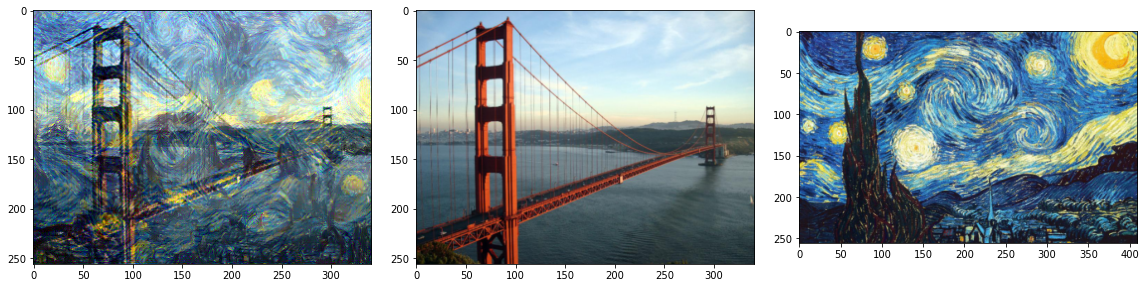

Iteration    175 | loss 38.4378471
  Content loss 1:  26.1348
  Style loss 1:     1.5504
  Style loss 2:     0.7593
  Style loss 3:     5.0138
  Style loss 4:     4.9668


In [ ]:
from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    grid(False)
    fig.add_subplot(133).imshow(style_image)
    grid(False)
    ax = fig.add_subplot(131)

    tight_layout()
    imsh = ax.imshow(to_np(image))
    grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        # image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

In [ ]:
plt.imshow(np.clip(to_np(image), 0.0, 1.0))
grid(False)